# Project 3: Reddit Scraping & NLP

## Part 3 - Preprocessing and Modeling

In [2]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# For Natural Language Processing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For Classification Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# For Evaluation
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, 
                             plot_roc_curve, roc_auc_score, classification_report,
                            precision_score, recall_score, f1_score)

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Preprocessing

In [3]:
# Read in cleaned data and reset index
df = pd.read_csv('../data/cleaned_posts.csv', index_col=False)
df.reset_index(inplace=True, drop=True)

In [4]:
df.head()

,created_utc,url,full_link,id,num_comments,title,selftext,subreddit,timestamp,is_mental,title_char_length,title_word_count,sentiment_comp,sentiment_neg,sentiment_neu,sentiment_pos
0,1611140689,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l172x7,3,Has anyone else been completely unable to moni...,I had a psychotic break which seemed to come o...,mentalhealth,2021-01-20 06:04:49,1,70,11,0.0000,0.00,1.000,0.000
1,1611140753,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l173gi,7,Is it normal to cry when you see someone you love,I know this sounds weird but i guess let me ex...,mentalhealth,2021-01-20 06:05:53,1,49,11,0.2732,0.19,0.552,0.258
2,1611141523,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l179ft,2,Somethings gotta give,Been living with my mom who has bad mental iss...,mentalhealth,2021-01-20 06:18:43,1,21,3,0.0000,0.00,1.000,0.000
3,1611141801,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l17bmq,2,Train Your Brain,NaN,mentalhealth,2021-01-20 06:23:21,1,16,3,0.0000,0.00,1.000,0.000
4,1611143753,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l17rke,3,Rage attacks?,Hello. \nI usually talk to myself (and Im pret...,mentalhealth,2021-01-20 06:55:53,1,13,2,-0.7579,1.00,0.000,0.000


In [5]:
# Check for missing values in title
df.title.isnull().sum()

0

In [6]:
df2 = pd.read_csv('../data/shared_words.csv')

In [7]:
shared_words = list(df2['shared_word'])

In [8]:
print(shared_words)

['help', 'like', 'health', 'know', 'i’m', 'just', 'need', 'does', 'don’t', 'think', 'people', 'time', 'going', 'getting', 'make', 'today', 'new', 'right', 'got', 'long', 'best', 'say']


In [9]:
# Create my_stopwords model parameter combining English stop words and subreddits shared words
my_stopwords = list(TfidfVectorizer(stop_words = 'english').get_stop_words()) + shared_words

### Modeling

#### The Null Model

In [10]:
# Define X and y
X = df['title']
y = df['is_mental']

In [11]:
# Check class distribution
y.value_counts(normalize=True)

1    0.500382
0    0.499618
Name: is_mental, dtype: float64

We can see here that 50.04% of posts are from r/mentalhealth, and 49.96% of posts are from r/CoronavirusUS. The null model is showing that selecting the label r/mentalthealth would result in correctly predicting what subreddit a post came from 50.04% of the time. My goal is to build a model that classifies posts with an accuracy higher than 50.04%.

#### Model 1: Logistic Regression

In [12]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up transformer and estimator via pipeline
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('logreg', LogisticRegression())
])

# Set up parameters for pipeline
lr_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'logreg__C': [0.1, 1, 10]  
}

# Instantiate GridSearchCV
gs_lr = GridSearchCV(estimator=pipe_lr,
                      param_grid=lr_params,
                      cv=5,
                      verbose=0)

# Fit GridSearchCV
gs_lr.fit(X_train, y_train)

# Accuracy score
gs_lr.score(X_train, y_train), gs_lr.score(X_test, y_test)

(0.9979612640163099, 0.9205702647657841)

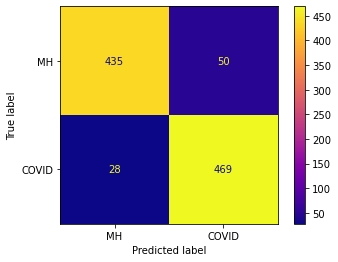

In [13]:
# Predicted y test values
lr_preds = gs_lr.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_lr, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [14]:
# Model evaluation metrics
print(classification_report(y_test, lr_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.94      0.90      0.92       485
       COVID       0.90      0.94      0.92       497

    accuracy                           0.92       982
   macro avg       0.92      0.92      0.92       982
weighted avg       0.92      0.92      0.92       982



In [15]:
# # Best parameters (uncomment to run)
# gs_lr.best_params_

{'logreg__C': 10,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

**Interpretation:** Model 1 is a logistic regression model that utilizes TF-IDF vectorizer and a pipline/gridsearch in order to predict the correct subreedit of a post. TF-IDF vectoriziation is used because it better differentiates rare words and gives weights to all of the words, unlike Countvectorizer which gives equal weights to all words. The most desirable parameters that maximizes accuracy include 'english" as the stop words, and an ngram range of (1,2), meaning the model creates unigram and bigram vectors. The testing accuracy score of 92.1% on unseen data means that this model surpasses the baseline model in its ability to classify reddit posts. However, given a training score of 99.86%, this model is clearly overfit. Between precision and recall, we are more concerned with not missing r/mentalhealth posts, and this model returns a recall score of .90, which is good. Overall, this model is still largely robust in it's ability to predict the correct subreddit of a post.

#### Model 2: Decision Tree Classifier

In [16]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up pipeline
pipe_dtc = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('dct', DecisionTreeClassifier(min_samples_leaf=2))
])

# Set up parameters for pipeline
dtc_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'dct__max_depth': [None, 10, 20, 40, 100]
}

# Instantiate GridSearchCV
gs_dtc = GridSearchCV(estimator=pipe_dtc,
                      param_grid=dtc_params,
                      cv=5,
                      verbose=0)

# Fit GridSearchCV
gs_dtc.fit(X_train, y_train)

# Accuracy score
gs_dtc.score(X_train, y_train), gs_dtc.score(X_test, y_test)

(0.9034998301053347, 0.895112016293279)

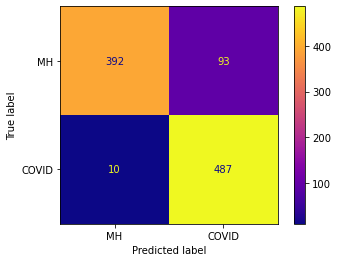

In [17]:
# Predicted y test values
dtc_preds = gs_dtc.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_dtc, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [18]:
# Model evaluation metrics
print(classification_report(y_test, dtc_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.98      0.81      0.88       485
       COVID       0.84      0.98      0.90       497

    accuracy                           0.90       982
   macro avg       0.91      0.89      0.89       982
weighted avg       0.91      0.90      0.89       982



In [19]:
# # Best parameters (uncomment to run)
# gs_dtc.best_params_

{'dct__max_depth': 40,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['toward',
  'hereby',
  'eleven',
  'against',
  'though',
  'who',
  'system',
  'all',
  'most',
  'empty',
  'myself',
  'thereupon',
  'only',
  'may',
  'where',
  'because',
  'together',
  'fire',
  'etc',
  'every',
  'own',
  'a',
  'take',
  'across',
  'forty',
  'less',
  'this',
  'than',
  'move',
  'serious',
  'its',
  'about',
  'has',
  'keep',
  'among',
  'becoming',
  'down',
  'beforehand',
  'everything',
  'elsewhere',
  'few',
  'with',
  'everyone',
  'after',
  'whoever',
  'or',
  'besides',
  'here',
  'nowhere',
  'were',
  'should',
  'namely',
  'anyway',
  'ltd',
  'seeming',
  'already',
  'rather',
  'almost',
  'through',
  'being',
  'once',
  'seemed',
  'next',
  'do',
  'below',
  'when',
  'our',
  'around',
  'enough',
  'if',
  'over',
  'often',
  'none',
  'always',
  'hers',
  'thereby',
  'although',
  'themselves',
  'these',
  'yours',
  'fill

**Interpretation:** Model 2's testing accuracy of 89.5% on unseen data means that this model surpasses the baseline model in its ability to classify reddit posts. Given a training score of 90.3%, this model shows a balanced bias-variance tradeoff. Between precision and recall, we are more concerned with not missing r/mentalhealth posts, and this model returns a recall score of .81, which is good, but not as high as Model 1.

#### Model 3: Bagging Classifier

In [20]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up pipeline
pipe_bag = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('bag', BaggingClassifier())
])

# Set up parameters for pipeline
bag_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'bag__n_estimators': [10, 15, 20]
}

# Instantiate GridSearchCV
gs_bag = GridSearchCV(estimator=pipe_bag,
                      param_grid=bag_params,
                      cv=5,
                      verbose=0)

# Fit GridSearchCV
gs_bag.fit(X_train, y_train)

# Accuracy score
gs_bag.score(X_train, y_train), gs_bag.score(X_test, y_test)

(0.9908256880733946, 0.9164969450101833)

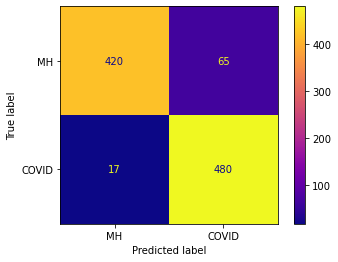

In [21]:
# Predicted y test values
bag_preds = gs_bag.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_bag, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [22]:
# Model evaluation metrics
print(classification_report(y_test, bag_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.96      0.87      0.91       485
       COVID       0.88      0.97      0.92       497

    accuracy                           0.92       982
   macro avg       0.92      0.92      0.92       982
weighted avg       0.92      0.92      0.92       982



In [23]:
# # Best parameters (uncomment to run)
# gs_bag.best_params_

{'bag__n_estimators': 15,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['toward',
  'hereby',
  'eleven',
  'against',
  'though',
  'who',
  'system',
  'all',
  'most',
  'empty',
  'myself',
  'thereupon',
  'only',
  'may',
  'where',
  'because',
  'together',
  'fire',
  'etc',
  'every',
  'own',
  'a',
  'take',
  'across',
  'forty',
  'less',
  'this',
  'than',
  'move',
  'serious',
  'its',
  'about',
  'has',
  'keep',
  'among',
  'becoming',
  'down',
  'beforehand',
  'everything',
  'elsewhere',
  'few',
  'with',
  'everyone',
  'after',
  'whoever',
  'or',
  'besides',
  'here',
  'nowhere',
  'were',
  'should',
  'namely',
  'anyway',
  'ltd',
  'seeming',
  'already',
  'rather',
  'almost',
  'through',
  'being',
  'once',
  'seemed',
  'next',
  'do',
  'below',
  'when',
  'our',
  'around',
  'enough',
  'if',
  'over',
  'often',
  'none',
  'always',
  'hers',
  'thereby',
  'although',
  'themselves',
  'these',
  'yours',
  'fi

**Interpretation:** Model 3's testing accuracy is 91.6% on unseen data, which means that this model surpasses the baseline model in its ability to classify reddit posts. Given a training score of 99.1%, this model is quite overfit. This model returns a recall score for mentalhealth posts of .87, which is good, but not as high as Model 1.

#### Model 4: Multinomial Naive Bayes

In [24]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up pipeline
pipe_mnb = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('mnb', MultinomialNB())
])

# Set up parameters for pipeline
mnb_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'mnb__alpha': [1.0, 0.75, 0.5, 0.25]
}

# Instantiate GridSearchCV
gs_mnb = GridSearchCV(pipe_mnb,
                      param_grid=mnb_params,
                      cv=5,
                     verbose=0)

# Fit GridSearchCV
gs_mnb.fit(X_train, y_train)

# Accuracy score
gs_mnb.score(X_train, y_train), gs_mnb.score(X_test, y_test)

(0.9932042133876996, 0.9063136456211812)

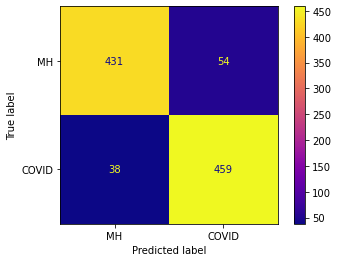

In [25]:
# Predicted y test values
mnb_preds = gs_mnb.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_mnb, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [26]:
# Model evaluation metrics
print(classification_report(y_test, mnb_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.92      0.89      0.90       485
       COVID       0.89      0.92      0.91       497

    accuracy                           0.91       982
   macro avg       0.91      0.91      0.91       982
weighted avg       0.91      0.91      0.91       982



In [27]:
# # Best parameters (uncomment to run)
# gs_mnb.best_params_

{'mnb__alpha': 0.25,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

**Interpretation:** Model 4's testing accuracy is 90.6% on unseen data, which means that this model surpasses the baseline model in its ability to classify reddit posts. Given a training score of 99.3%, this model is quite overfit. This model returns a recall score for mentalhealth posts of .89, which is high, but not as high as Model 1.

#### Model 5: AdaBoost Classifier

In [28]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up transformer and estimator via pipeline
pipe_abc = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('abc', AdaBoostClassifier())
])

# Set up parameters for pipeline
abc_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'abc__n_estimators': [25, 50, 100]
}

# Instantiate GridSearchCV    
gs_abc = GridSearchCV(pipe_abc,
                      param_grid=abc_params,
                      cv=5,
                     verbose=0)

# Fit GridSearchCV
gs_abc.fit(X_train,y_train)

# Accuracy score
gs_abc.score(X_train,y_train), gs_abc.score(X_test,y_test)

(0.9164118246687054, 0.8890020366598778)

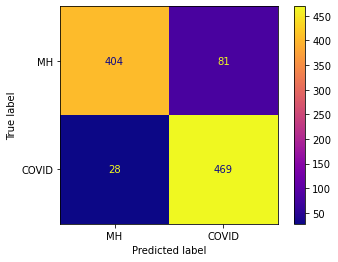

In [29]:
# Predicted y test values
abc_preds = gs_abc.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_abc, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [30]:
# Model evaluation metrics
print(classification_report(y_test, abc_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.94      0.83      0.88       485
       COVID       0.85      0.94      0.90       497

    accuracy                           0.89       982
   macro avg       0.89      0.89      0.89       982
weighted avg       0.89      0.89      0.89       982



In [31]:
# # Best parameters (uncomment to run)
# gs_abc.best_params_

{'abc__n_estimators': 100,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

**Interpretation:** Model 5's testing accuracy is 88.9% on unseen data, which means that this model surpasses the baseline model in its ability to classify reddit posts. Given a training score of 91.6%, this model has a balanced bias-variance tradeoff. This model returns a recall score for mentalhealth posts of .83, which is good, but not as high as Model 1.

#### Model 6: Random Forest Classifier

In [32]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up pipeline
pipe_rfc = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('rfc', RandomForestClassifier())
])

# Set up parameters for pipeline
rfc_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'rfc__n_estimators': [50, 100, 200],
    'rfc__max_depth': [None, 5, 10, 20]
}

# Instantiate GridSearchCV
gs_rfc = GridSearchCV(estimator=pipe_rfc,
                      param_grid=rfc_params,
                      cv=5,
                      verbose=0)

# Fit GridSearchCV
gs_rfc.fit(X_train, y_train)

# Accuracy score for random forest
gs_rfc.score(X_train, y_train), gs_rfc.score(X_test, y_test)

(0.9979612640163099, 0.924643584521385)

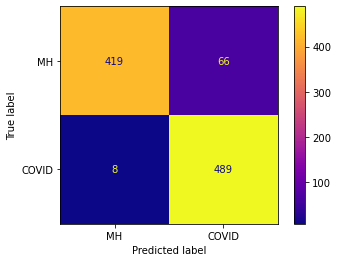

In [33]:
# Predicted y test values
rfc_preds = gs_rfc.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_rfc, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [34]:
# Model evaluation metrics
print(classification_report(y_test, rfc_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.98      0.86      0.92       485
       COVID       0.88      0.98      0.93       497

    accuracy                           0.92       982
   macro avg       0.93      0.92      0.92       982
weighted avg       0.93      0.92      0.92       982



In [35]:
# # Best parameters (uncomment to run)
# gs_rfc.best_params_

{'rfc__max_depth': None,
 'rfc__n_estimators': 200,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['toward',
  'hereby',
  'eleven',
  'against',
  'though',
  'who',
  'system',
  'all',
  'most',
  'empty',
  'myself',
  'thereupon',
  'only',
  'may',
  'where',
  'because',
  'together',
  'fire',
  'etc',
  'every',
  'own',
  'a',
  'take',
  'across',
  'forty',
  'less',
  'this',
  'than',
  'move',
  'serious',
  'its',
  'about',
  'has',
  'keep',
  'among',
  'becoming',
  'down',
  'beforehand',
  'everything',
  'elsewhere',
  'few',
  'with',
  'everyone',
  'after',
  'whoever',
  'or',
  'besides',
  'here',
  'nowhere',
  'were',
  'should',
  'namely',
  'anyway',
  'ltd',
  'seeming',
  'already',
  'rather',
  'almost',
  'through',
  'being',
  'once',
  'seemed',
  'next',
  'do',
  'below',
  'when',
  'our',
  'around',
  'enough',
  'if',
  'over',
  'often',
  'none',
  'always',
  'hers',
  'thereby',
  'although',
  'themselves',
 

**Interpretation:** Model 6's testing accuracy is 92.5% on unseen data, which means that this model surpasses the baseline model in its ability to classify reddit posts. Given a training score of 99.8%, this model has extrememly high training accuracy but is extremely overfit. This model returns a recall score for mentalhealth posts of .86, which is good, but not as high as Model 1.

#### Model 7: Support Vector Classifier

In [36]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up transformer and estimator via pipeline
pipe_svc = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('svc', SVC())
])

# Set up parameters for pipeline
svc_params = {
    'tvec__stop_words': [None, 'english', my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Instantiate GridSearchCV    
gs_svc = GridSearchCV(pipe_svc,
                      param_grid=svc_params,
                      cv=5,
                     verbose=0)

# Fit GridSearchCV
gs_svc.fit(X_train,y_train)

# Accuracy score
gs_svc.score(X_train,y_train), gs_svc.score(X_test,y_test)

(0.9945633707101597, 0.9175152749490835)

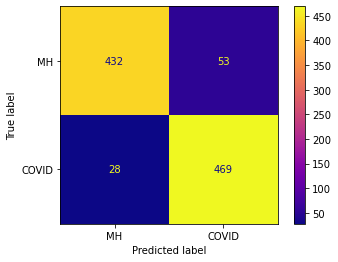

In [37]:
# Predicted y test values
svc_preds = gs_svc.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_svc, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [38]:
# Model evaluation metrics
print(classification_report(y_test, svc_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.94      0.89      0.91       485
       COVID       0.90      0.94      0.92       497

    accuracy                           0.92       982
   macro avg       0.92      0.92      0.92       982
weighted avg       0.92      0.92      0.92       982



In [39]:
# # Best parameters (uncomment to run)
# gs_svc.best_params_

{'svc__kernel': 'linear',
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

**Interpretation:** Model 7's testing accuracy is 91.8% on unseen data, which means that this model surpasses the baseline model in its ability to classify reddit posts. Given a training score of 99.5%, this model is quite overfit. This model returns a recall score for mentalhealth posts of .89, which is high, but not as high as Model 1.

### Production Model

Because the logistic regression model had the highest performance in terms of accuracy, I did addtional analysis on posts incorrectly classified from this model.

In [40]:
# Create Dataframe with correct and incorrect predictions
lr_df = pd.DataFrame({'title': X_test, 'true_subreddit': y_test,
                      'predicted_subreddit': gs_lr.predict(X_test)})
# Create Dataframe with only incorrect predictions
lr_df = lr_df.loc[lr_df['true_subreddit'] != lr_df['predicted_subreddit']]

In [41]:
# View Dataframe with incorrect predictions
lr_df.head()

,title,true_subreddit,predicted_subreddit
3598,Delta employee: “I f*cked the captain to keep ...,0,1
270,Fake personality with EVERYONE,1,0
720,Associating negative emotions with positive im...,1,0
3487,Can someone explain to me as if I am a toddler,0,1
3867,"Employers just don't care and denial is real, ...",0,1


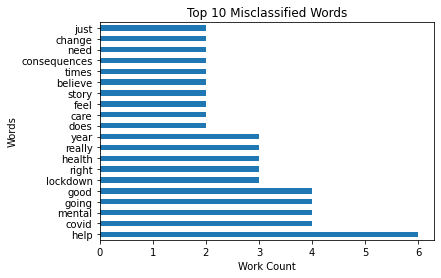

In [42]:
# Define X
X = lr_df['title']

# Instantiate a CV object
cv = CountVectorizer(stop_words='english', token_pattern = r'[\w{2,}\d*]\S*\w+')

# Fit and transform the CV
X_cv = cv.fit_transform(X)

# Convert to a dataframe
cv_df = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names_out())

# Plot the top 10 words that are misclassified
cv_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 10 Misclassified Words')
plt.xlabel('Work Count')
plt.ylabel('Words');

In [43]:
misclassified_words = cv_df.sum().sort_values(ascending=False)

In [44]:
len(shared_words)

22

In [45]:
# created list of common words between misclassified popular and my stop words
misclassified_shared_words = []
for word in misclassified_words.index:
    if word in shared_words:
        misclassified_shared_words.append(word)
print(len(misclassified_shared_words))
print(misclassified_shared_words)

17
['help', 'going', 'right', 'health', 'does', 'need', 'just', 'long', 'don’t', 'know', 'people', 'new', 'today', 'time', 'like', 'best', 'getting']


**Interpretation:** The model most frequently misclassifies posts where the 17 words shown above appear. Out of the 22 words included in the "shared_words" list, 17 of these words are present in the misclassified posts. The original logisitic regression model didn't included the "shared_word" list as part of it's stop words. How will the model perform if we include the "shared_words" list in the stop word list?

In [46]:
# Define X and y
X = df['title']
y = df['is_mental']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up transformer and estimator via pipeline
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer(token_pattern=r'[\w{2,}\d*]\S*\w+')),
    ('logreg', LogisticRegression())
])

# Set up parameters for pipeline
lr_params = {
    'tvec__stop_words': [my_stopwords],
    'tvec__min_df': [1, 5, 10],
    'tvec__ngram_range': [(1,1), (1,2), (2,2)],
    'logreg__C': [0.1, .9, 1, 1.1, 10]  
}

# Instantiate GridSearchCV
gs_lr = GridSearchCV(estimator=pipe_lr,
                      param_grid=lr_params,
                      cv=5,
                      verbose=0)

# Fit GridSearchCV
gs_lr.fit(X_train, y_train)

# Accuracy score
gs_lr.score(X_train, y_train), gs_lr.score(X_test, y_test)

(0.9979612640163099, 0.9205702647657841)

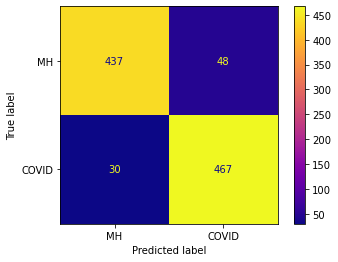

In [47]:
# Predicted y test values
lr_preds = gs_lr.predict(X_test)

# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_lr, X_test, y_test, display_labels=['MH','COVID'], cmap='plasma');

In [48]:
# Model evaluation metrics
print(classification_report(y_test, lr_preds, target_names=['MH', 'COVID']))

              precision    recall  f1-score   support

          MH       0.94      0.90      0.92       485
       COVID       0.91      0.94      0.92       497

    accuracy                           0.92       982
   macro avg       0.92      0.92      0.92       982
weighted avg       0.92      0.92      0.92       982



**Interpretation:** This logistic regression model performs virtually the same - r/mentalhealth recall is marginally higher (it misclassified 48 posts instead of the original 50), but the model is still slightly overfit.

#### Evaluate tfidf weights

In [49]:
# Instantiate and fit the transformer
tvec = TfidfVectorizer(stop_words='english', min_df=1)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

# Instantiate and fit logistic regression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_tvec, y_train)

# Create a dataframe showing the feature name and tf-idf weight of the word
my_dict = dict(zip(tvec.get_feature_names_out(), tvec.idf_))
features_df = pd.DataFrame(data=my_dict.items(), columns=['feature_name','tfidf_weight'])

# View the 10 highest weighted feature names
features_df.sort_values(by=['tfidf_weight'], ascending=False).head(10)

,feature_name,tfidf_weight
2372,landlord,8.294377
2763,mundo,8.294377
2747,motive,8.294377
2749,mounted,8.294377
2750,mounts,8.294377
2751,mourning,8.294377
2752,movements,8.294377
2753,movie,8.294377
2756,mta,8.294377
2757,mthfr,8.294377


**Interpretion:** Words with a weight of 8.294377 influence the classification the most.

In [50]:
# ROC AUC Score
roc_auc_score(y_test, gs_lr.predict_proba(X_test)[:, 1])

0.9757721587255491

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


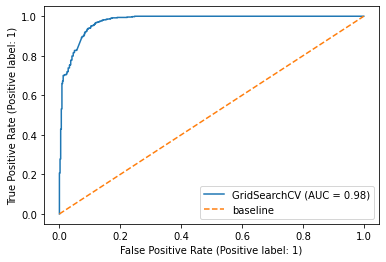

In [51]:
# Receiver Operating Characteristic (ROC) Curve
plot_roc_curve(gs_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
        label='baseline', linestyle='--')
plt.legend();

**Interpretation:** The area under the ROC curve tells how much the model is capable of distingusihing between classes. More area under the curve means the distributions are better separated. This ROC AUC of 0.98 indicates that the true positive rate and the false positive rate are well separated.

In [54]:
# Since my production model utilizing the custom stopword list has a marginally higher recall score
# for mentalhealth posts, I'm going to pickle this model 
with open('../data/production_model.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(gs_lr, pickle_out)

## Conclusion

My baseline model had an accuracy score of 50%, and my logistic regression model has an accuracy of 92.1%, showing that the logisitc regression model is significantly better at predicting the correct subreddit.

